---

В этом ноутбке мы научимся писать свои свёрточные нейросети на фреймворке PyTorch, и протестируем их работу на датасетах MNIST и CIFAR10. 

**ВНИМАНИЕ:** Рассматривается ***задача классификации изображений***.

(Подразумевается, что читатель уже знаком с многослойной нейроннной сетью).  

***Свёрточная нейросеть (Convolutional Neural Network, CNN)*** - это многослойная нейросеть, имеющая в своей архитектуре помимо *полносвязных слоёв* (а иногда их может и не быть) ещё и **свёрточные слои (Conv Layers)** и **pooling-слои (Pool Layers)**.  

Собственно, название такое эти сети получили потому, что в основе их работы лежит операция **свёртки**. 


Сразу же стоит сказать, что свёрточные нейросети **были придуманы прежде всего для задач, связанных с картинками**, следовательно, на вход они тоже "ожидают" картинку.

Расмотрим их устройство более подробно:

* Вот так выглядит неглубокая свёрточная нейросеть, имеющая такую архитектуру:  
`Input -> Conv 5x5 -> Pool 2x2 -> Conv 5x5 -> Pool 2x2 -> FC -> Output`

<img src="https://camo.githubusercontent.com/269e3903f62eb2c4d13ac4c9ab979510010f8968/68747470733a2f2f7261772e6769746875622e636f6d2f746176677265656e2f6c616e647573655f636c617373696669636174696f6e2f6d61737465722f66696c652f636e6e2e706e673f7261773d74727565" width=800, height=600>

Свёрточные нейросети (обыкновенные, есть и намного более продвинутые) почти всегда строятся по следующему правилу:  

`INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC`  

то есть:  

1). ***Входной слой*** (batch картинок `HxWxC`)  

2). $M$ блоков (M $\ge$ 0) из свёрток и pooling-ов, причём именно в том порядке, как в формуле выше. Все эти $M$ блоков вместе называют ***feature extractor*** свёрточной нейросети, потому что эта часть сети отвечает непосредственно за формирование новых, более сложных признаков, поверх тех, которые подаются (то есть, по аналогии с MLP, мы опять же переходим к новому признаковому пространству, однако здесь оно строится сложнее, чтем в обычных многослойных сетях, поскольку используется операция свёртки)  

3). $K$ штук FullyConnected-слоёв (с активациями). Эту часть из $K$ FC-слоёв называют ***classificator***, поскольку эти слои отвечают непосредственно за предсказание нужно класса (сейчас рассматривается задача классификации изображений).


<h3 style="text-align: center;"><b>Свёрточная нейросеть на PyTorch</b></h3>

Ешё раз напомним про основные компоненты нейросети:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

Так как мы сейчас рассматриваем **архитектуру CNN**, то, помимо этих компонент, в свёрточной нейросети можно настроить следующие вещи:  

- (в каждом ConvLayer) **размер фильтров (окна свёртки)** (`kernel_size`)
- (в каждом ConvLayer) **количество фильтров** (`out_channels`)  
- (в каждом ConvLayer) размер **шага окна свёртки (stride)** (`stride`)  
- (в каждом ConvLayer) **тип padding'а** (`padding`)  


- (в каждом PoolLayer) **размер окна pooling'a** (`kernel_size`)  
- (в каждом PoolLayer) **шаг окна pooling'а** (`stride`)  
- (в каждом PoolLayer) **тип pooling'а** (`pool_type`)  
- (в каждом PoolLayer) **тип padding'а** (`padding`)

Какими их берут обычно -- будет показано в примере ниже. По крайней мере, можете стартовать с этих настроек, чтобы понять, какое качество "из коробки" будет у простой модели.

Посмотрим, как работает CNN на MNIST'е и на CIFAR'е:

<img src="http://present5.com/presentation/20143288_415358496/image-8.jpg" width=500, height=400>

**MNIST:** это набор из 70k картинок рукописных цифр от 0 до 9, написанных людьми, 60k из которых являются тренировочной выборкой (`train` dataset)), и ещё 10k выделены для тестирования модели (`test` dataset).

In [0]:
import torch
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

Скачаем и загрузим в `loader`'ы:

**Обратите внимание на аргумент `batch_size`:** именно он будет отвечать за размер батча, который будет подаваться при оптимизации нейросети

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

Сами данные лежат в полях `trainloader.dataset.train_data` и `testloader.dataset.test_data`:

In [4]:
trainloader.dataset.train_data.shape

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

In [5]:
testloader.dataset.test_data.shape

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([10000, 28, 28])

Выведем первую картинку:

In [6]:
trainloader.dataset.train_data[0]

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

Посмотрим, как она выглядит:

In [7]:
# преобразовать тензор в np.array
numpy_img = trainloader.dataset.train_data[0].numpy()

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [8]:
numpy_img.shape

(28, 28)

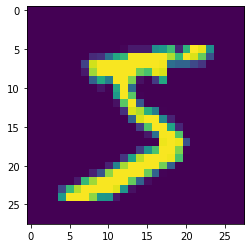

In [9]:
plt.imshow(numpy_img);

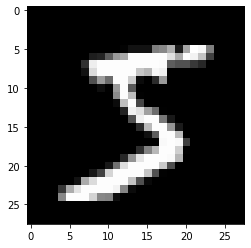

In [10]:
plt.imshow(numpy_img, cmap='gray');

Отрисовка заданной цифры:

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


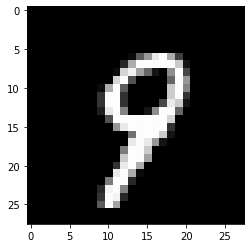

In [11]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=60000)

plt.imshow(trainloader.dataset.train_data[i].numpy(), cmap='gray');

Как итерироваться по данным с помощью `loader'`а? Очень просто:

In [12]:
for data in trainloader:
    print(data)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
   

То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 4), причём в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Теперь вернёмся к тому, что в PyTorch есть две "парадигмы" построения нейросетей -- `Functional` и `Seuquential`. Со второй мы уже хорошенько разобрались в предыдущих ноутбуках по нейросетям, теперь мы испольузем именно `Functional` парадигму, потому что при построении свёрточных сетей это намного удобнее:

In [0]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [0]:
# ЗАМЕТЬТЕ: КЛАСС НАСЛЕДУЕТСЯ ОТ nn.Module
class SimpleConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleConvNet, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 4 * 4 * 16)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**Важное примечание:** Вы можете заметить, что в строчках с `#!!!` есть не очень понятный сходу 4 `*` 4 `*` 16. Это -- размерность картинки перед FC-слоями (H x W x C), тут её приходиться высчитывать вручную (в Keras, например, `.Flatten()` всё делает за Вас). Однако есть один *лайфхак* -- просто сделайте в `forward()` `print(x.shape)` (закомментированная строка). Вы увидите размер `(batch_size, C, H, W)` -- нужно перемножить все, кроме первого (batch_size), это и будет первая размерность `Linear()`, и именно в C * H * W нужно "развернуть" x перед подачей в `Linear()`.  

То есть нужно будет запустить цикл с обучением первый раз с `print()` и сделать после него `break`, посчитать размер, вписать его в нужные места и стереть `print()` и `break`.

Код обучения слоя:

In [0]:
from tqdm import tqdm_notebook

In [16]:
# объявляем сеть
net = SimpleConvNet()

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(3)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


[1,  2000] loss: 0.943
[1,  4000] loss: 0.350
[1,  6000] loss: 0.289
[1,  8000] loss: 0.238
[1, 10000] loss: 0.209
[1, 12000] loss: 0.172
[1, 14000] loss: 0.152



[2,  2000] loss: 0.131
[2,  4000] loss: 0.119
[2,  6000] loss: 0.111
[2,  8000] loss: 0.108
[2, 10000] loss: 0.108
[2, 12000] loss: 0.105
[2, 14000] loss: 0.094



[3,  2000] loss: 0.078
[3,  4000] loss: 0.085
[3,  6000] loss: 0.078
[3,  8000] loss: 0.079
[3, 10000] loss: 0.075
[3, 12000] loss: 0.081
[3, 14000] loss: 0.078


Обучение закончено


Протестируем на всём тестовом датасете, используя метрику accuracy_score:

In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 96 %
Accuracy of     3 : 96 %
Accuracy of     4 : 98 %
Accuracy of     5 : 98 %
Accuracy of     6 : 97 %
Accuracy of     7 : 98 %
Accuracy of     8 : 97 %
Accuracy of     9 : 97 %


Два свёрточных слоя побили многослойную нейросеть. Не магия ли?

---

### Задача 1

Протестируйте эту нейросеть на отдельных картинках из тестового датасета: напишите функцию, которая принимает индекс картинки в тестовом датасете, отрисовывает её, потом запускает на ней модель (нейросеть) и выводит результат предсказания.

In [0]:
def number_info(id):
    _index_ = [id]
    subset = torch.utils.data.Subset(testloader.dataset, _index_)
    testloader_subset = torch.utils.data.DataLoader(subset, batch_size=1, num_workers=0, shuffle=False)
    for image, label in testloader_subset:
        numpy_img = image[0][0].numpy()
        plt.imshow(numpy_img, cmap='gray');
        print(f'изначально было: {label.numpy()[0]}')
        pred = net(image)
        _, predicted = torch.max(pred, 1)
        print(f'предсказание: {predicted.numpy()[0]}')

изначально было: 1
предсказание: 1


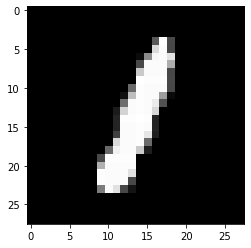

In [24]:
number_info(137)

---

<h3 style="text-align: center;"><b>CIFAR10</b></h3>

<img src="https://raw.githubusercontent.com/soumith/ex/gh-pages/assets/cifar10.png" width=500, height=400>

**CIFAR10:** это набор из 60k картинок 32х32х3, 50k которых составляют обучающую выборку, и оставшиеся 10k - тестовую. Классов в этом датасете 10: `'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'`.

Скачаем и загрузим в `loader`'ы:

**Обратите внимание на аргумент `batch_size`:** именн он будет отвечать за размер батча, который будет подаваться при оптимизации нейросети

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


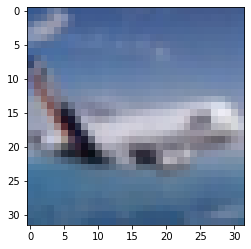

In [28]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=50000)

plt.imshow(trainloader.dataset.data[i], cmap='gray');

То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 4), причём в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Данные готовы, мы даже на них посмотрели. **Однако учтите** - при подаче в нейросеть мы будем разворачивать картинку 32х32х3 в строку 1х(32`*`32`*`3) = 1х3072, то есть мы считаем пиксели (значения интенсивности в пикселях) за признаки нашего объекта (картинки).  

К делу:

### Задача 2

Напишите свою свёрточную нейросеть для предсказания на CIFAR10.

In [0]:
class MyConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Обучим:

In [0]:
from tqdm import tqdm_notebook

In [31]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

net = MyConvNet()

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(3)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # РАЗВОРАЧИВАЕМ КАРТИНКУ В СТРОКУ
        #X_batch = X_batch.view(4, -1)

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выводем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


[1,  2000] loss: 2.036
[1,  4000] loss: 1.847
[1,  6000] loss: 1.756
[1,  8000] loss: 1.670
[1, 10000] loss: 1.643
[1, 12000] loss: 1.598



[2,  2000] loss: 1.558
[2,  4000] loss: 1.549
[2,  6000] loss: 1.519
[2,  8000] loss: 1.475
[2, 10000] loss: 1.474
[2, 12000] loss: 1.457



[3,  2000] loss: 1.438
[3,  4000] loss: 1.435
[3,  6000] loss: 1.405
[3,  8000] loss: 1.399
[3, 10000] loss: 1.381
[3, 12000] loss: 1.365


Обучение закончено


Посмотрим на accuracy на тестовом датасете:

In [32]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
print('average accuracy: ', np.mean(100 * np.array(class_correct) / np.array(class_total)))

Accuracy of plane : 49 %
Accuracy of   car : 58 %
Accuracy of  bird : 44 %
Accuracy of   cat : 44 %
Accuracy of  deer : 28 %
Accuracy of   dog : 44 %
Accuracy of  frog : 56 %
Accuracy of horse : 56 %
Accuracy of  ship : 65 %
Accuracy of truck : 63 %
average accuracy:  51.11


Как думаете, этого достаточно?

### Задача 3  

Улучшите свёрточную нейросеть: поэкспериментируйте с архитектурой (количество слоёв, порядок слоёв), с гиперпараметрами слоёв (размеры kernel_size, размеры pooling'а, количество kernel'ов в свёрточном слое) и с гиперпараметрами, указанными в "Компоненты нейросети" (см. памятку выше).

In [0]:
class MyConvNet2(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(MyConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.drop_layer = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(16 * 5 * 5, 216)
        self.fc2 = nn.Linear(216, 96)
        self.fc3 = nn.Linear(96, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [34]:
net2 = MyConvNet2()

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(net2.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(5)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # РАЗВОРАЧИВАЕМ КАРТИНКУ В СТРОКУ
        #X_batch = X_batch.view(4, -1)

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net2(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выводем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


[1,  2000] loss: 1.847
[1,  4000] loss: 1.594
[1,  6000] loss: 1.518
[1,  8000] loss: 1.423
[1, 10000] loss: 1.397
[1, 12000] loss: 1.336



[2,  2000] loss: 1.264
[2,  4000] loss: 1.259
[2,  6000] loss: 1.221
[2,  8000] loss: 1.233
[2, 10000] loss: 1.205
[2, 12000] loss: 1.216



[3,  2000] loss: 1.099
[3,  4000] loss: 1.130
[3,  6000] loss: 1.104
[3,  8000] loss: 1.128
[3, 10000] loss: 1.124
[3, 12000] loss: 1.106



[4,  2000] loss: 1.030
[4,  4000] loss: 1.035
[4,  6000] loss: 1.044
[4,  8000] loss: 1.030
[4, 10000] loss: 1.038
[4, 12000] loss: 1.032



[5,  2000] loss: 0.969
[5,  4000] loss: 0.980
[5,  6000] loss: 0.997
[5,  8000] loss: 0.980
[5, 10000] loss: 0.966
[5, 12000] loss: 0.989


Обучение закончено


In [35]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net2(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
print('average accuracy: ', np.mean(100 * np.array(class_correct) / np.array(class_total)))

Accuracy of plane : 55 %
Accuracy of   car : 66 %
Accuracy of  bird : 56 %
Accuracy of   cat : 44 %
Accuracy of  deer : 60 %
Accuracy of   dog : 40 %
Accuracy of  frog : 72 %
Accuracy of horse : 66 %
Accuracy of  ship : 78 %
Accuracy of truck : 73 %
average accuracy:  61.3


In [0]:
class MyConvNet3(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(MyConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 80)
        self.fc2 = nn.Linear(80, 60)
        self.fc3 = nn.Linear(60, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [37]:
net3 = MyConvNet3()

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net3.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(3)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # РАЗВОРАЧИВАЕМ КАРТИНКУ В СТРОКУ
        #X_batch = X_batch.view(4, -1)

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net3(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выводем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


[1,  2000] loss: 2.092
[1,  4000] loss: 1.914
[1,  6000] loss: 1.798
[1,  8000] loss: 1.731
[1, 10000] loss: 1.667
[1, 12000] loss: 1.631



[2,  2000] loss: 1.576
[2,  4000] loss: 1.573
[2,  6000] loss: 1.548
[2,  8000] loss: 1.549
[2, 10000] loss: 1.503
[2, 12000] loss: 1.503



[3,  2000] loss: 1.474
[3,  4000] loss: 1.461
[3,  6000] loss: 1.460
[3,  8000] loss: 1.437
[3, 10000] loss: 1.426
[3, 12000] loss: 1.429


Обучение закончено


In [38]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net3(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
print('average accuracy: ', np.mean(100 * np.array(class_correct) / np.array(class_total)))

Accuracy of plane : 53 %
Accuracy of   car : 64 %
Accuracy of  bird : 32 %
Accuracy of   cat : 25 %
Accuracy of  deer : 23 %
Accuracy of   dog : 46 %
Accuracy of  frog : 64 %
Accuracy of horse : 60 %
Accuracy of  ship : 66 %
Accuracy of truck : 56 %
average accuracy:  49.35


In [0]:
class MyConvNet4(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(MyConvNet4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 320)
        self.fc2 = nn.Linear(320, 160)
        self.fc3 = nn.Linear(160, 80)
        self.fc4 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
net4 = MyConvNet4()

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(net4.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(3)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # РАЗВОРАЧИВАЕМ КАРТИНКУ В СТРОКУ
        #X_batch = X_batch.view(4, -1)

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net4(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выводем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


[1,  2000] loss: 1.929
[1,  4000] loss: 1.588
[1,  6000] loss: 1.479
[1,  8000] loss: 1.429
[1, 10000] loss: 1.382
[1, 12000] loss: 1.358



[2,  2000] loss: 1.280
[2,  4000] loss: 1.255
[2,  6000] loss: 1.226
[2,  8000] loss: 1.236
[2, 10000] loss: 1.244
[2, 12000] loss: 1.221



[3,  2000] loss: 1.134
[3,  4000] loss: 1.130
[3,  6000] loss: 1.142
[3,  8000] loss: 1.127
[3, 10000] loss: 1.137
[3, 12000] loss: 1.131


Обучение закончено


In [28]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net4(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

print('average accuracy: ', np.mean(100 * np.array(class_correct) / np.array(class_total)))

Accuracy of plane : 64 %
Accuracy of   car : 82 %
Accuracy of  bird : 40 %
Accuracy of   cat : 17 %
Accuracy of  deer : 43 %
Accuracy of   dog : 59 %
Accuracy of  frog : 67 %
Accuracy of horse : 74 %
Accuracy of  ship : 79 %
Accuracy of truck : 57 %
average accuracy:  58.8


In [0]:
class MyConvNet5(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(MyConvNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.drop_layer = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(16 * 5 * 5, 320)
        self.fc2 = nn.Linear(320, 80)
        self.fc3 = nn.Linear(80, 10)
        self.fc4 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [45]:
net5 = MyConvNet5()

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-3 * 2
optimizer = torch.optim.Adam(net5.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(5)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # РАЗВОРАЧИВАЕМ КАРТИНКУ В СТРОКУ
        #X_batch = X_batch.view(4, -1)

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net5(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выводем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


[1,  2000] loss: 1.948
[1,  4000] loss: 1.753
[1,  6000] loss: 1.664
[1,  8000] loss: 1.592
[1, 10000] loss: 1.580
[1, 12000] loss: 1.553



[2,  2000] loss: 1.501
[2,  4000] loss: 1.496
[2,  6000] loss: 1.484
[2,  8000] loss: 1.469
[2, 10000] loss: 1.450
[2, 12000] loss: 1.459



[3,  2000] loss: 1.384
[3,  4000] loss: 1.377
[3,  6000] loss: 1.377
[3,  8000] loss: 1.386
[3, 10000] loss: 1.400
[3, 12000] loss: 1.357



[4,  2000] loss: 1.309
[4,  4000] loss: 1.307
[4,  6000] loss: 1.324
[4,  8000] loss: 1.332
[4, 10000] loss: 1.337
[4, 12000] loss: 1.314



[5,  2000] loss: 1.253
[5,  4000] loss: 1.260
[5,  6000] loss: 1.289
[5,  8000] loss: 1.259
[5, 10000] loss: 1.292
[5, 12000] loss: 1.293


Обучение закончено


In [46]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net4(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

print('average accuracy: ', np.mean(100 * np.array(class_correct) / np.array(class_total)))

Accuracy of plane : 64 %
Accuracy of   car : 82 %
Accuracy of  bird : 40 %
Accuracy of   cat : 17 %
Accuracy of  deer : 43 %
Accuracy of   dog : 59 %
Accuracy of  frog : 67 %
Accuracy of horse : 74 %
Accuracy of  ship : 79 %
Accuracy of truck : 57 %
average accuracy:  58.8


In [43]:
print('average accuracy: ', np.mean(100 * np.array(class_correct) / np.array(class_total)))

average accuracy:  58.8


In [0]:
class MyConvNet6(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(MyConvNet6, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.drop_layer = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(16 * 5 * 5, 400)
        self.fc2 = nn.Linear(400, 216)
        self.fc3 = nn.Linear(216, 96)
        self.fc4 = nn.Linear(96, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [54]:
net6 = MyConvNet6()

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(net6.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(5)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # РАЗВОРАЧИВАЕМ КАРТИНКУ В СТРОКУ
        #X_batch = X_batch.view(4, -1)

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net6(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выводем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


[1,  2000] loss: 1.884
[1,  4000] loss: 1.582
[1,  6000] loss: 1.476
[1,  8000] loss: 1.419
[1, 10000] loss: 1.412
[1, 12000] loss: 1.377



[2,  2000] loss: 1.272
[2,  4000] loss: 1.265
[2,  6000] loss: 1.258
[2,  8000] loss: 1.239
[2, 10000] loss: 1.224
[2, 12000] loss: 1.221



[3,  2000] loss: 1.103
[3,  4000] loss: 1.123
[3,  6000] loss: 1.143
[3,  8000] loss: 1.138
[3, 10000] loss: 1.138
[3, 12000] loss: 1.135



[4,  2000] loss: 1.015
[4,  4000] loss: 1.043
[4,  6000] loss: 1.053
[4,  8000] loss: 1.061
[4, 10000] loss: 1.060
[4, 12000] loss: 1.081



[5,  2000] loss: 0.932
[5,  4000] loss: 0.969
[5,  6000] loss: 0.998
[5,  8000] loss: 1.015
[5, 10000] loss: 0.979
[5, 12000] loss: 1.023


Обучение закончено


In [55]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net4(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

print('average accuracy: ', np.mean(100 * np.array(class_correct) / np.array(class_total)))

Accuracy of plane : 64 %
Accuracy of   car : 82 %
Accuracy of  bird : 40 %
Accuracy of   cat : 17 %
Accuracy of  deer : 43 %
Accuracy of   dog : 59 %
Accuracy of  frog : 67 %
Accuracy of horse : 74 %
Accuracy of  ship : 79 %
Accuracy of truck : 57 %
average accuracy:  58.8


(Ожидаемый результат -- скорее всего, сходу Вам не удастся выжать из Вашей сетки больше, чем ~70% accuracy (в среднем по всем классам). Если это что-то в этом районе - Вы хорошо постарались).

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам свёрточных нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/convolutional-networks/  
http://cs231n.github.io/understanding-cnn/  
http://cs231n.github.io/transfer-learning/

4). Видео о Computer Vision от Andrej Karpathy: https://www.youtube.com/watch?v=u6aEYuemt0M